### Load Packages
***

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from cvxopt import matrix, solvers
from tqdm.auto import tqdm

### 2 Reinforcement learning (RL)
***

#### Question 1: (10 points) For visualization purpose, generate heat maps of Reward function 1 and Reward function 2. For the heat maps, make sure you display the coloring scale. You will have 2 plots for this question.
> Ans:

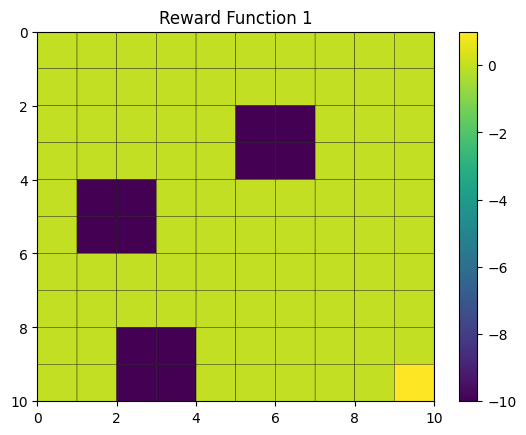

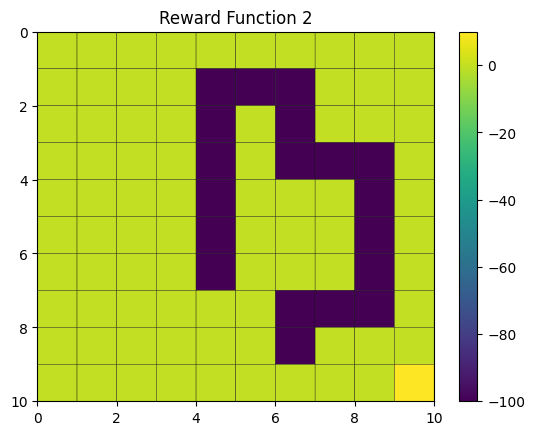

In [2]:
reward_func1 = np.array(
    [
        [0,0,0,0,0,0,0,0,0,0], 
        [0,0,0,0,0,0,0,0,0,0], 
        [0,0,0,0,0,-10,-10,0,0,0], 
        [0,0,0,0,0,-10,-10,0,0,0],
        [0,-10,-10,0,0,0,0,0,0,0],
        [0,-10,-10,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0],
        [0,0,-10,-10,0,0,0,0,0,0],
        [0,0,-10,-10,0,0,0,0,0,1],
    ]
)

reward_func2 = np.array(
    [
        [0,0,0,0,0,0,0,0,0,0], 
        [0,0,0,0,-100,-100,-100,0,0,0], 
        [0,0,0,0,-100,0,-100,0,0,0], 
        [0,0,0,0,-100,0,-100,-100,-100,0],
        [0,0,0,0,-100,0,0,0,-100,0],
        [0,0,0,0,-100,0,0,0,-100,0],
        [0,0,0,0,-100,0,0,0,-100,0],
        [0,0,0,0,0,0,-100,-100,-100,0],
        [0,0,0,0,0,0,-100,0,0,0],
        [0,0,0,0,0,0,0,0,0,10],
    ]
)



def plot_heatmap(grid, title):
    plt.pcolor(grid, edgecolors="black")
    plt.gca().invert_yaxis()
    plt.colorbar()
    plt.title(title)
    plt.show()


plot_heatmap(reward_func1, "Reward Function 1")
plot_heatmap(reward_func2, "Reward Function 2")

### 3 Optimal policy learning using RL algorithms
***

#### Question 2: (40 points) Create the environment of the agent using the information provided in section 2. To be specific, create the MDP by setting up the state-space, action set, transition probabilities, discount factor, and reward function. For creating the environment, use the following set of parameters:
+ Number of states = 100 (state space is a 10 by 10 square grid as displayed in figure 1)
+ Number of actions = 4 (set of possible actions is displayed in figure 2)
+ w = 0.1
+ Discount factor = 0.8
+ Reward function 1
#### After you have created the environment, then write an optimal state-value function that takes as input the environment of the agent and outputs the optimal value of each state in the grid. For the optimal state-value function, you have to implement the Initialization (lines 2-4) and Estimation (lines 5-13) steps of the Value Iteration algorithm. For the estimation step, use  = 0.01. For visualization purpose, you should generate a figure similar to that of figure 1 but with the number of state replaced by the optimal value of that state. In this part of question, you should have 1 plot. Let’s assume that your value iteration algorithm converges in N steps. Plot snapshots of state values in 5 different steps linearly distributed from 1 to N. Report N and your step numbers. What observations do you have from the plots?

> Ans: 

In [3]:
def compute_tps(w):
    tps_u = np.zeros((100, 100))
    tps_d = np.zeros((100, 100))
    tps_l = np.zeros((100, 100))
    tps_r = np.zeros((100, 100))
    
    for i in range(100):
        if i%10 == 0:
            tps_u[i][i] += w/4
            tps_d[i][i] += w/4
            tps_l[i][i] += w/4
            tps_r[i][i] += w/4
        else:
            tps_u[i][i-1] = 1-w+w/4
            tps_d[i][i-1] = w/4
            tps_l[i][i-1] = w/4
            tps_r[i][i-1] = w/4
        if i-10 < 0:
            tps_u[i][i] += w/4
            tps_d[i][i] += w/4
            tps_l[i][i] += w/4
            tps_r[i][i] += w/4
        else:
            tps_u[i][i-10] = w/4
            tps_d[i][i-10] = w/4
            tps_l[i][i-10] = 1-w+w/4
            tps_r[i][i-10] = w/4
        if i+10 > 99:
            tps_u[i][i] += w/4
            tps_d[i][i] += w/4
            tps_l[i][i] += w/4
            tps_r[i][i] += w/4
        else:
            tps_u[i][i+10] = w/4
            tps_d[i][i+10] = w/4
            tps_l[i][i+10] = w/4
            tps_r[i][i+10] = 1-w+w/4
        if (i+1)%10 == 0:
            tps_u[i][i] += w/4
            tps_d[i][i] += w/4
            tps_l[i][i] += w/4
            tps_r[i][i] += w/4
        else:
            tps_u[i][i+1] = w/4
            tps_d[i][i+1] = 1-w+w/4
            tps_l[i][i+1] = w/4
            tps_r[i][i+1] = w/4
        if i%10 == 0:                     
            tps_u[i][i] += 1-w
        if (i+1)%10 == 0:                      
            tps_d[i][i] += 1-w
        if i-10 < 0:                      
            tps_l[i][i] += 1-w
        if i+10 > 99:                      
            tps_r[i][i] += 1-w

    return tps_u, tps_d, tps_l, tps_r

Number of steps to converge: 22


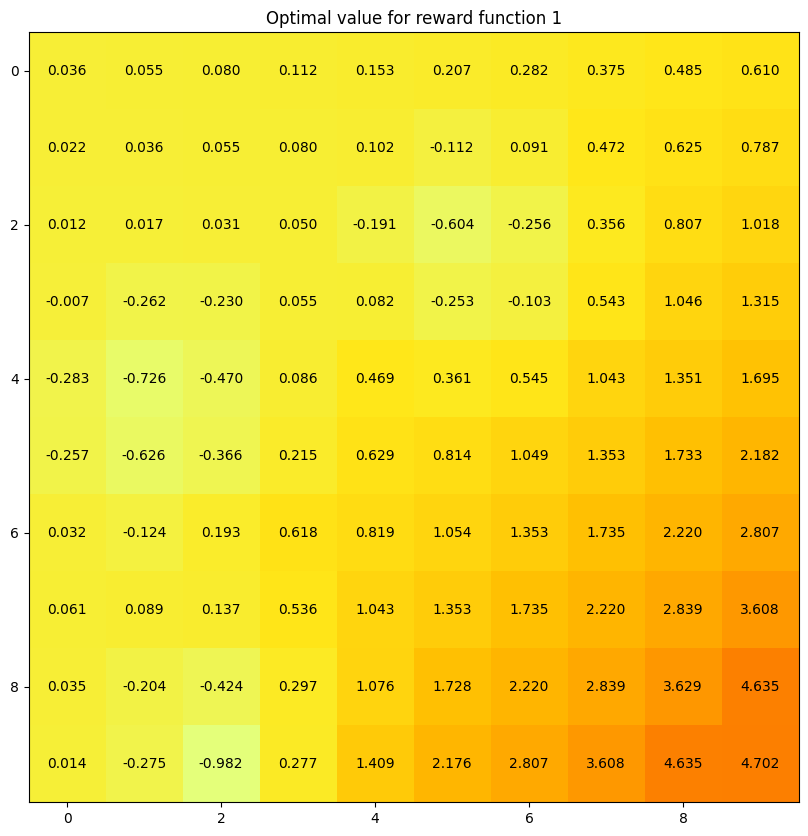

In [4]:
def get_state_value_snapshots(w, gamma, reward_func, epsilon):
    tps_u, tps_d, tps_l, tps_r = compute_tps(w)
    state_values = np.zeros(100)
    delta = np.inf
    r = (reward_func.T).ravel()
    N = 0
    snapshots = []
    
    while delta > epsilon:
        delta = 0
        old_state_values = np.copy(state_values)
        for s in range(100):
            u_val = np.sum(tps_u[s]*(r + gamma*old_state_values))
            d_val = np.sum(tps_d[s]*(r + gamma*old_state_values))
            l_val = np.sum(tps_l[s]*(r + gamma*old_state_values))
            r_val = np.sum(tps_r[s]*(r + gamma*old_state_values))
            state_values[s] = max(u_val, d_val, r_val, l_val)
            delta = max(delta, abs(old_state_values[s]-state_values[s]))
        N += 1
        snapshots.append(np.copy(state_values).reshape(10,10).T)

    print("Number of steps to converge:", len(snapshots))
    return snapshots


def plot_state_values(state_values, title):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(state_values, cmap="Wistia")
    for i in range(10):
        for j in range(10):
            c = "{:.3f}".format(state_values[j, i])
            ax.text(i, j, str(c), va="center", ha="center")
    plt.title(title)
    plt.show()


w = 0.1
gamma = 0.8
epsilon = 0.01
snapshots = get_state_value_snapshots(w, gamma, reward_func1, epsilon)
plot_state_values(snapshots[-1], "Optimal value for reward function 1")

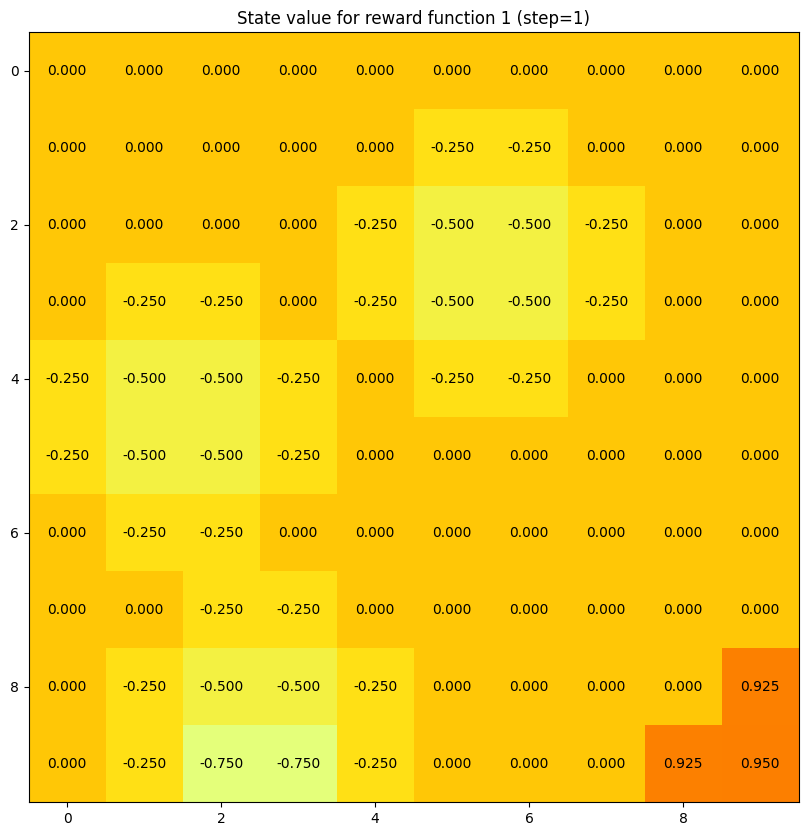

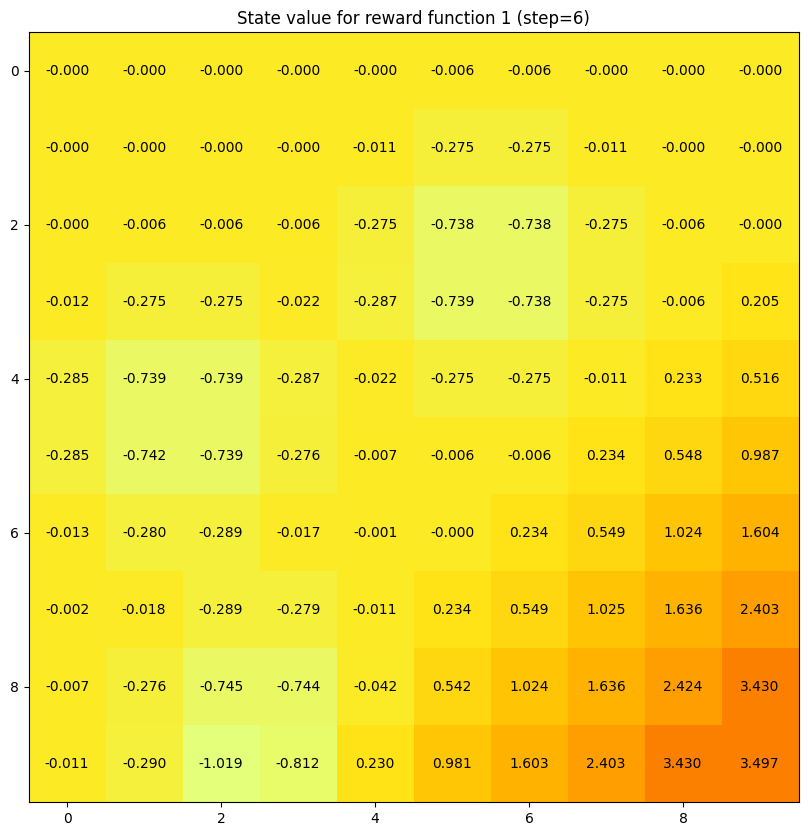

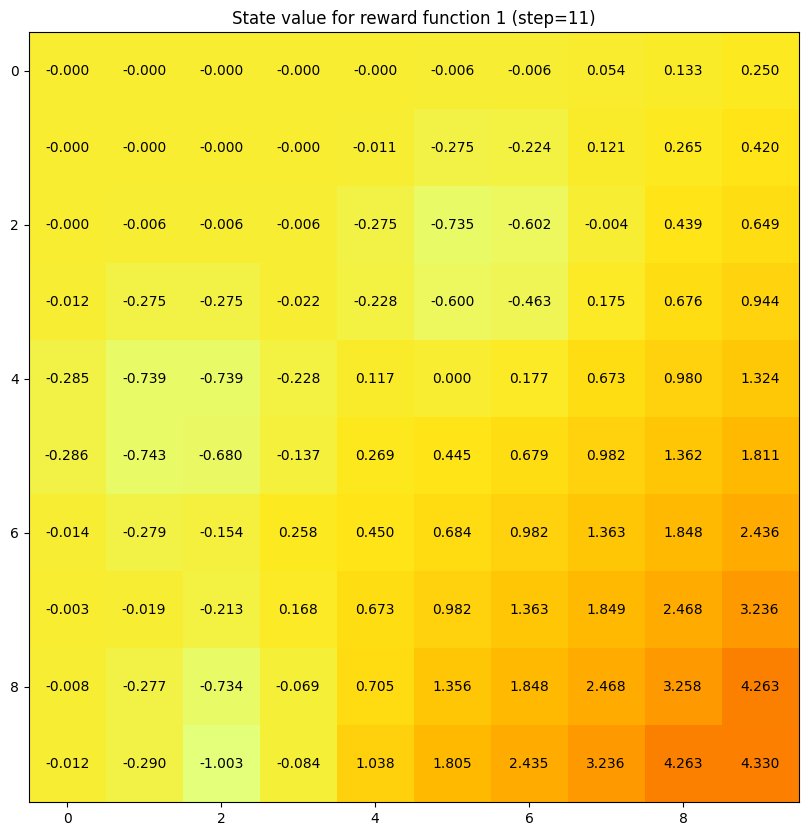

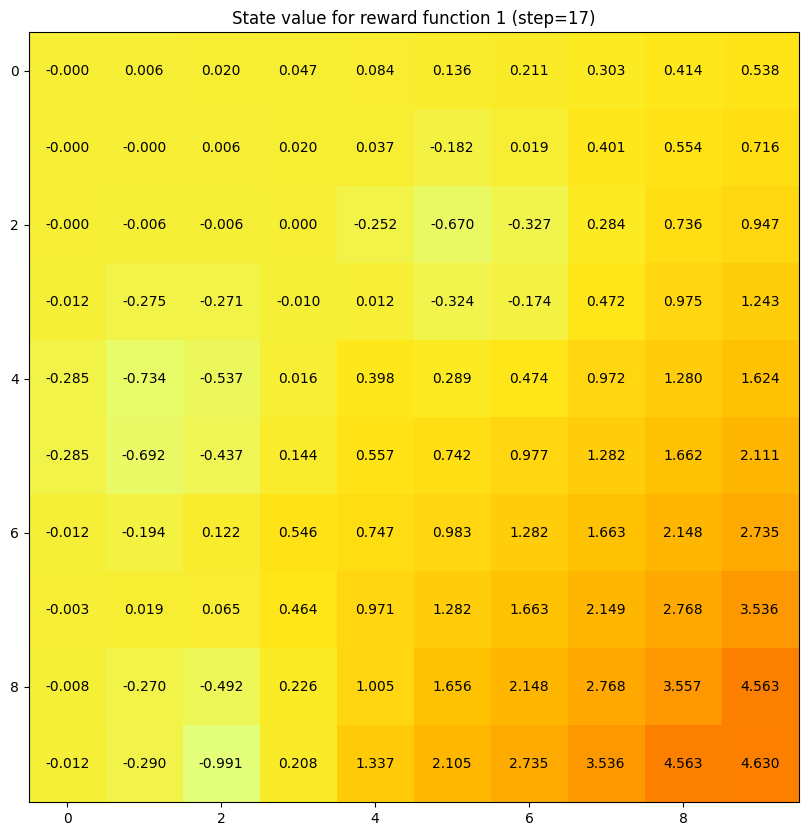

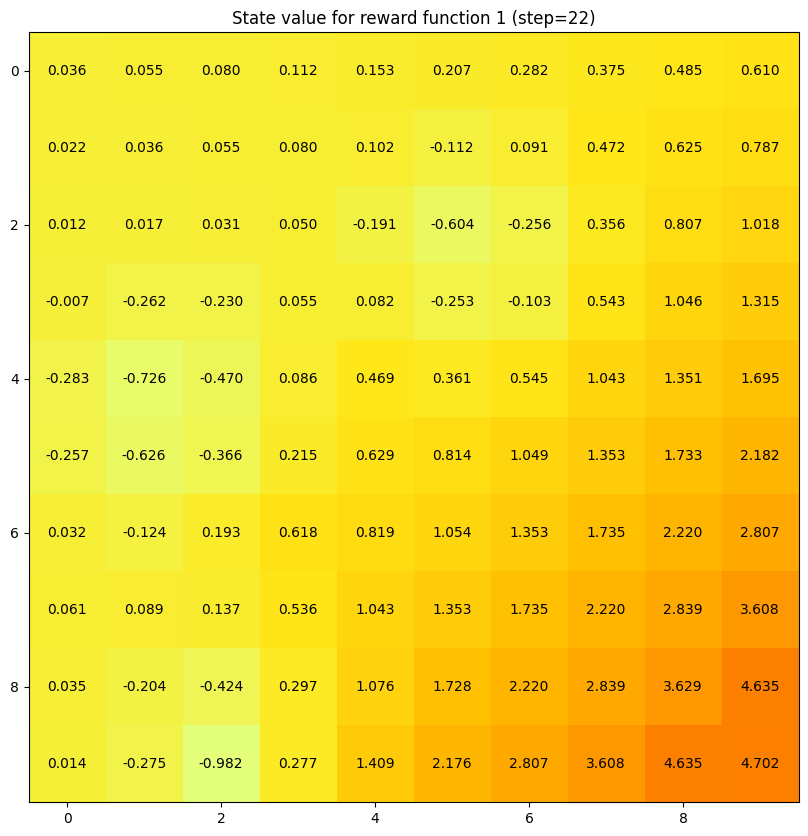

In [5]:
chosen_idxs = [0, 5, 10, 16, 21]
for i in chosen_idxs:
    plot_state_values(snapshots[i], f"State value for reward function 1 (step={i+1})")

#### Question 3: (5 points) Generate a heat map of the optimal state values across the 2-D grid. For generating the heat map, you can use the same function provided in the hint earlier (see the hint after question 1).
> Ans:

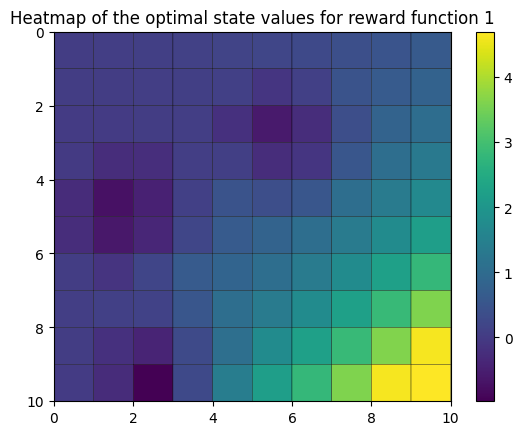

In [6]:
plot_heatmap(snapshots[-1], "Heatmap of the optimal state values for reward function 1")

#### Question 4: (15 points) Explain the distribution of the optimal state values across the 2-D grid. (Hint: Use the figure generated in question 3 to explain)

> Ans: 

#### Question 5: (20 points) Implement the computation step of the value iteration algorithm (lines 14-17) to compute the optimal policy of the agent navigating the 2-D state-space. For visualization purpose, you should generate a figure similar to that of figure 1 but with the number of state replaced by the optimal action at that state. The optimal actions should be displayed using arrows. Does the optimal policy of the agent match your intuition? Please provide a brief explanation. Is it possible for the agent to compute the optimal action to take at each state by observing the optimal values of it’s neighboring states? In this question, you should have 1 plot.

> Ans: 

In [7]:
def get_optimal_policy(w, gamma, reward_func, epsilon):
    tps_u, tps_d, tps_l, tps_r = compute_tps(w)
    state_values = np.zeros(100)
    delta = np.inf
    r = (reward_func.T).ravel()
    
    while delta > epsilon:
        delta = 0
        old_state_values = np.copy(state_values)
        for s in range(100):
            u_val = np.sum(tps_u[s]*(r + gamma*old_state_values))
            d_val = np.sum(tps_d[s]*(r + gamma*old_state_values))
            l_val = np.sum(tps_l[s]*(r + gamma*old_state_values))
            r_val = np.sum(tps_r[s]*(r + gamma*old_state_values))
            state_values[s] = max(u_val, d_val, r_val, l_val)
            delta = max(delta, abs(old_state_values[s]-state_values[s]))
    
    arrows = [u"\u2191", u"\u2193", u"\u2190", u"\u2192"]
    optimal_policy = []

    for s in range(100):
        u_val = np.sum(tps_u[s]*(r + gamma*state_values))
        d_val = np.sum(tps_d[s]*(r + gamma*state_values))
        l_val = np.sum(tps_l[s]*(r + gamma*state_values))
        r_val = np.sum(tps_r[s]*(r + gamma*state_values))
        arr = [u_val, d_val, l_val, r_val]
        optimal_policy.append(arrows[arr.index(np.amax(arr))])

    optimal_policy = np.array(optimal_policy).reshape(10, 10).T
    return optimal_policy


optimal_policy = get_optimal_policy(w, gamma, reward_func1, epsilon)
optimal_policy

array([['→', '→', '→', '→', '→', '→', '→', '→', '↓', '↓'],
       ['→', '→', '→', '↑', '↑', '↑', '→', '→', '↓', '↓'],
       ['↑', '↑', '↑', '↑', '↑', '↑', '→', '→', '↓', '↓'],
       ['↑', '↑', '→', '↓', '↓', '↓', '↓', '→', '↓', '↓'],
       ['↑', '↑', '→', '→', '↓', '↓', '↓', '↓', '↓', '↓'],
       ['↓', '↓', '→', '→', '↓', '↓', '↓', '↓', '↓', '↓'],
       ['↓', '→', '→', '→', '→', '→', '→', '↓', '↓', '↓'],
       ['→', '→', '→', '→', '→', '→', '→', '→', '↓', '↓'],
       ['↑', '↑', '↑', '→', '→', '→', '→', '→', '→', '↓'],
       ['↑', '←', '←', '→', '→', '→', '→', '→', '→', '↓']], dtype='<U1')

#### Question 6: (10 points) Modify the environment of the agent by replacing Reward function 1 with Reward function 2. Use the optimal state-value function implemented in question 2 to compute the optimal value of each state in the grid. For visualization purpose, you should generate a figure similar to that of figure 1 but with the number of state replaced by the optimal value of that state. In this question, you should have 1 plot.

> Ans: 

Number of steps to converge: 32


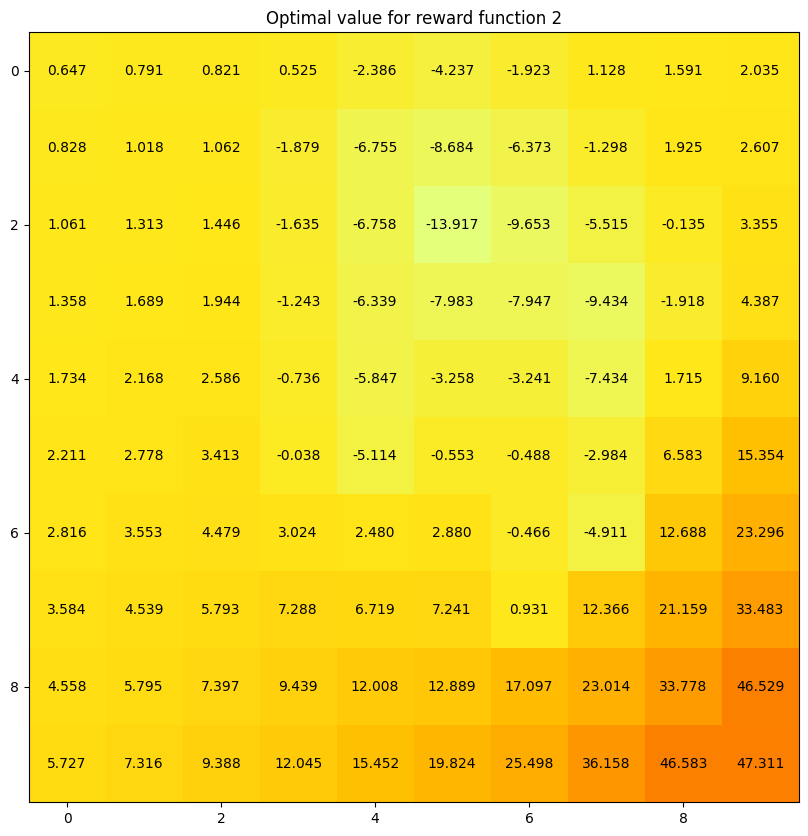

In [8]:
snapshots = get_state_value_snapshots(w, gamma, reward_func2, epsilon)
plot_state_values(snapshots[-1], "Optimal value for reward function 2")

#### Question 7: (20 points) Generate a heat map of the optimal state values (found in question 6) across the 2-D grid. For generating the heat map, you can use the same function provided in the hint earlier. Explain the distribution of the optimal state values across the 2-D grid. (Hint: Use the figure generated in this question to explain)

> Ans:

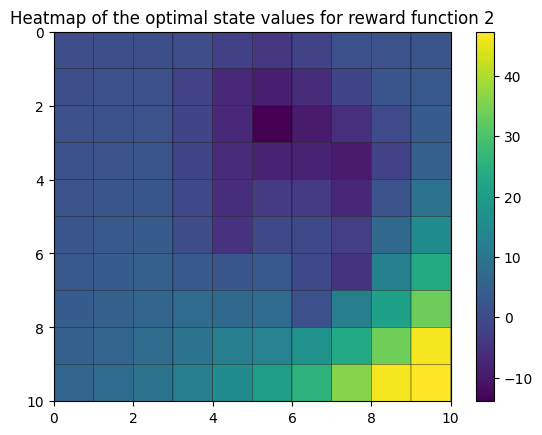

In [9]:
plot_heatmap(snapshots[-1], "Heatmap of the optimal state values for reward function 2")

#### Question 8: (20 points) Implement the computation step of the value iteration algorithm (lines 14-17) to compute the optimal policy of the agent navigating the 2-D state-space. For visualization purpose, you should generate a figure similar to that of figure 1 but with the number of state replaced by the optimal action at that state. The optimal actions should be displayed using arrows. Does the optimal policy of the agent match your intuition? Please provide a brief explanation. In this question, you should have 1 plot.

> Ans: 

In [10]:
optimal_policy = get_optimal_policy(w, gamma, reward_func2, epsilon)
optimal_policy

array([['↓', '↓', '↓', '←', '←', '→', '→', '→', '→', '↓'],
       ['↓', '↓', '↓', '←', '←', '↑', '→', '→', '→', '↓'],
       ['↓', '↓', '↓', '←', '←', '↓', '→', '→', '→', '↓'],
       ['↓', '↓', '↓', '←', '←', '↓', '↓', '↑', '→', '↓'],
       ['↓', '↓', '↓', '←', '←', '↓', '↓', '↓', '→', '↓'],
       ['↓', '↓', '↓', '←', '←', '↓', '↓', '←', '→', '↓'],
       ['↓', '↓', '↓', '↓', '↓', '↓', '←', '←', '→', '↓'],
       ['↓', '↓', '↓', '↓', '↓', '↓', '←', '↓', '↓', '↓'],
       ['→', '→', '→', '↓', '↓', '↓', '↓', '↓', '↓', '↓'],
       ['→', '→', '→', '→', '→', '→', '→', '→', '→', '↓']], dtype='<U1')

#### Question 9:(20 points) Change the hyper parameter w to 0.6 and find the optimal policy map similar to previous question for reward functions. Explain the differences you observe. What do you think about value of new w compared to previous value? Choose the w that you think give rise to better optimal policy and use that w for the next stages of the project.

Number of steps to converge: 19


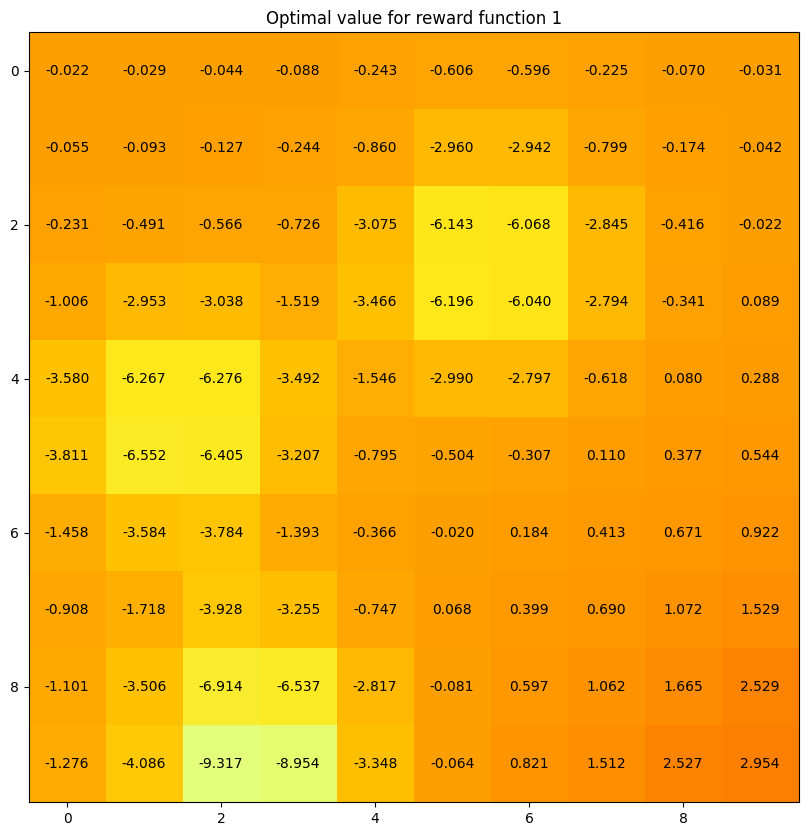

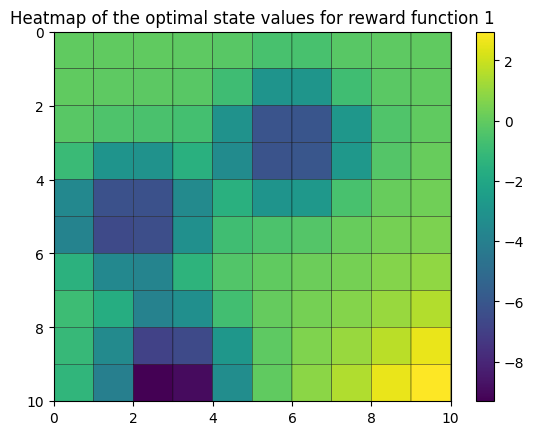

array([['↑', '←', '←', '←', '←', '←', '→', '→', '→', '↑'],
       ['↑', '↑', '↑', '↑', '↑', '↑', '↑', '→', '→', '↓'],
       ['↑', '↑', '↑', '↑', '←', '↑', '→', '→', '→', '↓'],
       ['↑', '↑', '↑', '↑', '←', '↓', '→', '→', '→', '↓'],
       ['↑', '↑', '↑', '↑', '↓', '↓', '↓', '↓', '↓', '↓'],
       ['↓', '↓', '→', '→', '↓', '↓', '↓', '↓', '↓', '↓'],
       ['↓', '←', '→', '→', '→', '→', '→', '↓', '↓', '↓'],
       ['←', '←', '←', '→', '→', '→', '→', '→', '↓', '↓'],
       ['↑', '←', '←', '→', '→', '→', '→', '→', '→', '↓'],
       ['↑', '←', '←', '→', '→', '→', '→', '→', '→', '↓']], dtype='<U1')

In [11]:
w = 0.6
snapshots = get_state_value_snapshots(w, gamma, reward_func1, epsilon)
plot_state_values(snapshots[-1], "Optimal value for reward function 1")
plot_heatmap(snapshots[-1], "Heatmap of the optimal state values for reward function 1")
optimal_policy = get_optimal_policy(w, gamma, reward_func1, epsilon)
optimal_policy

Number of steps to converge: 27


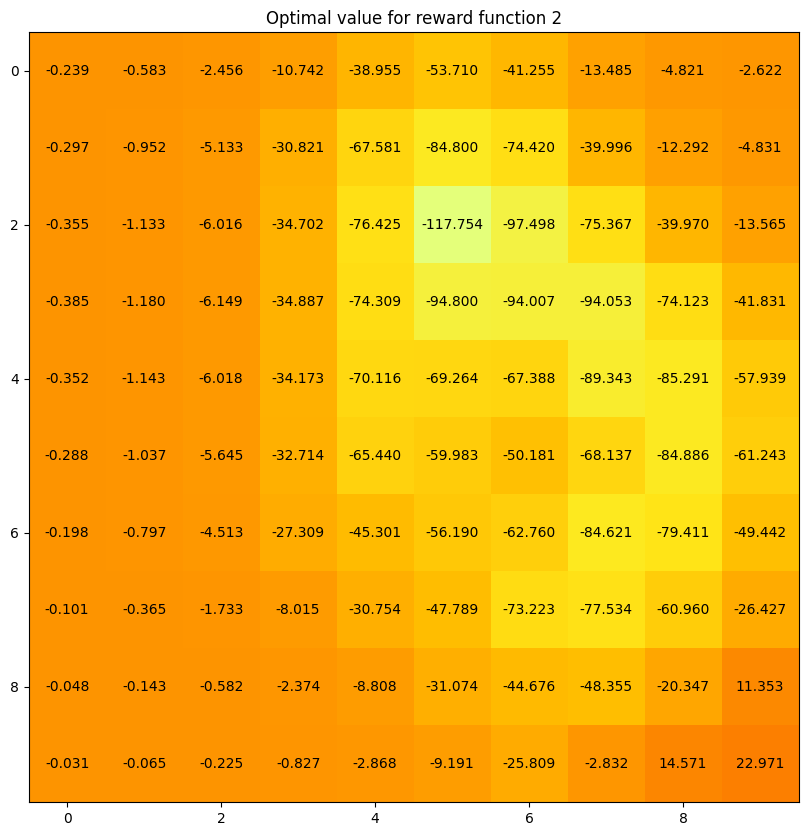

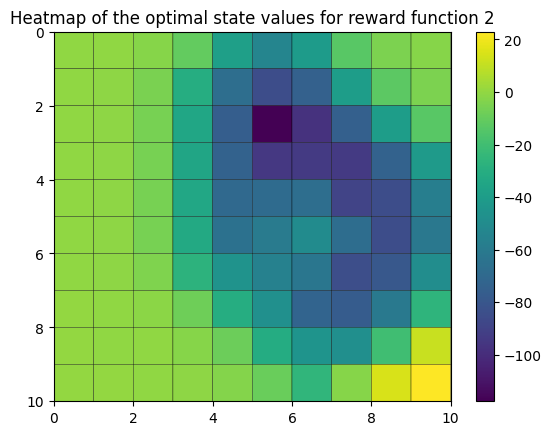

array([['↑', '←', '←', '←', '←', '←', '→', '→', '→', '↑'],
       ['↑', '←', '←', '←', '←', '↑', '→', '→', '↑', '↑'],
       ['↑', '←', '←', '←', '←', '↓', '→', '→', '↑', '↑'],
       ['↓', '←', '←', '←', '←', '↓', '↓', '↑', '↑', '↑'],
       ['↓', '←', '←', '←', '←', '↓', '↓', '←', '→', '↑'],
       ['↓', '←', '←', '←', '←', '→', '←', '←', '→', '↓'],
       ['↓', '←', '←', '←', '←', '↓', '↑', '←', '→', '↓'],
       ['↓', '←', '←', '←', '←', '←', '←', '↓', '↓', '↓'],
       ['↓', '←', '←', '←', '←', '←', '↓', '↓', '↓', '↓'],
       ['↓', '←', '←', '←', '←', '←', '→', '→', '→', '↓']], dtype='<U1')

In [12]:
snapshots = get_state_value_snapshots(w, gamma, reward_func2, epsilon)
plot_state_values(snapshots[-1], "Optimal value for reward function 2")
plot_heatmap(snapshots[-1], "Heatmap of the optimal state values for reward function 2")
optimal_policy = get_optimal_policy(w, gamma, reward_func2, epsilon)
optimal_policy

### 4 Inverse Reinforcement learning (IRL)
***

#### Question 10: (10 points) Express c, x, D, b in terms of R, Pa, Pa1 , ti , u, λ and Rmax

> Ans:

#### Question 11: (30 points) Sweep λ from 0 to 5 to get 500 evenly spaced values for λ. For each value of λ compute OA(s) by following the process described above. For this problem, use the optimal policy of the agent found in question 5 to fill in the OE(s) values. Then use equation 3 to compute the accuracy of the IRL algorithm for this value of λ. You need to repeat the above process for all 500 values of λ to get 500 data points. Plot λ (x-axis) against Accuracy (y-axis). In this question, you should have 1 plot.

> Ans: 

In [13]:
def get_matrices(optimal_policy, gamma, lambda_, r_max):
    arrow_map = {u"\u2191": 0, u"\u2193": 1, u"\u2190": 2, u"\u2192":3}
    Ps = list(compute_tps(w))
    P_exp = []
    P_ags = [[], [], []]

    for s in range(100):
        exp_act = arrow_map[optimal_policy[s]]
        agent = 0
        for action in range(4):
            if action == exp_act:
                P_exp.append(Ps[action][s])
            else:
                P_ags[agent].append(Ps[action][s])
                agent += 1

    P_exp = np.array(P_exp)
    I = np.eye(100)
    zero = np.zeros((100, 100))
    D = np.concatenate((zero, zero, zero, zero))
    D = np.concatenate(
        (D, np.concatenate((-I, -I, zero, zero)), np.concatenate((I, -I, I, -I))), 1
    )
 
    for Pa in P_ags:
        tmp = np.dot((np.array(Pa) - P_exp), np.linalg.inv(I - gamma*P_exp))
        tmp1 = np.concatenate((I, zero, tmp), 1)
        tmp2 = np.concatenate((zero, zero, tmp), 1)
        D = np.concatenate((np.concatenate((tmp1, tmp2)), D))
        
    c1 = np.array([-1. for _ in range(100)])
    c2 = np.array([lambda_ for _ in range(100)])
    c3 = np.array([0.0 for _ in range(100)])
    c = np.concatenate((c1, c2, c3), axis=0)

    b1 = np.array([0.0 for _ in range(800)])
    b2 = np.array([r_max for _ in range(200)])
    b = np.concatenate((b1, b2), axis=0)
    return c, D, b

In [14]:
def plot_and_get_accuracies(lambdas, optimal_policy, gamma, r_max, title):
    I = np.identity(100)
    accs = []
    
    for lambda_ in tqdm(lambdas):
        rewards = get_lp_rewards(optimal_policy, gamma, lambda_, r_max)
        agent_policy = get_optimal_policy(w, gamma, rewards, epsilon)
        agent_policy = agent_policy.T.flatten()
        acc = (agent_policy == optimal_policy).mean()
        accs.append(acc)

    plt.plot(lambdas, accs)
    plt.xlabel("Lambda")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.show()
    
    return accs


def get_lp_rewards(optimal_policy, gamma, lambda_, r_max):
    c, D, b = get_matrices(optimal_policy, gamma, lambda_, r_max)
    solvers.options["show_progress"] = False
    solution = solvers.lp(matrix(c), matrix(D), matrix(b))
    return np.array(solution["x"][-100:])

  0%|          | 0/501 [00:00<?, ?it/s]

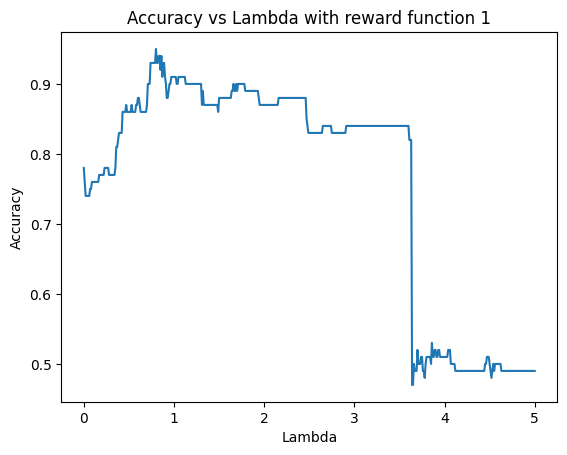

In [15]:
w = 0.1
gamma = 0.8
epsilon = 0.01
optimal_policy = get_optimal_policy(w, gamma, reward_func1, epsilon)
optimal_policy = optimal_policy.T.flatten()

lambdas = np.arange(0, 5.01, 0.01)
r_max = reward_func1.max()
title = "Accuracy vs Lambda with reward function 1"
accs = plot_and_get_accuracies(lambdas, optimal_policy, gamma, r_max, title)

#### Question 12: (5 points) Use the plot in question 11 to compute the value of λ for which accuracy is maximum. For future reference we will denote this value as λ(1)max. Please report λ(1)max.

> Ans:

In [17]:
lambda_max1 = lambdas[np.argmax(accs)]
print("Max accuracy:", max(accs))
print("λ(1)max:", lambda_max1)

Max accuracy: 0.95
λ(1)max: 0.8


#### Question 13: (15 points) For λ(1)max, generate heat maps of the ground truth reward and the extracted reward. Please note that the ground truth reward is the Reward function 1 and the extracted reward is computed by solving the linear program given by equation 2 with the λ parameter set to λ(1)max. In this question, you should have 2 plots.

> Ans:

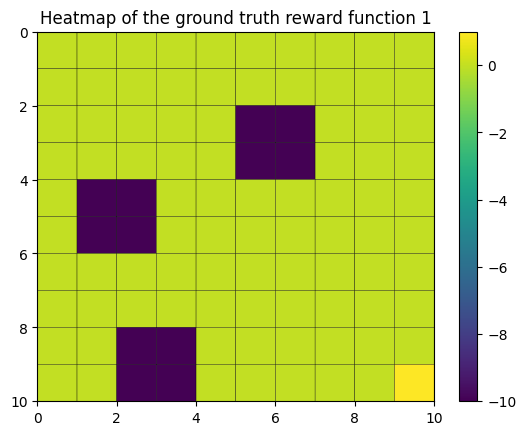

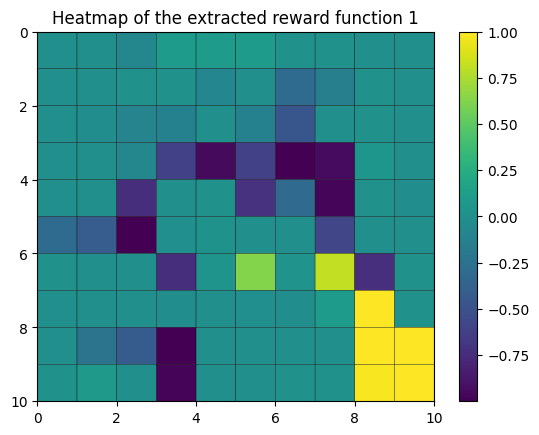

In [18]:
rewards = get_lp_rewards(optimal_policy, gamma, lambda_max1, r_max)
rewards = rewards.reshape(10,10).T
plot_heatmap(reward_func1, "Heatmap of the ground truth reward function 1")
plot_heatmap(rewards, "Heatmap of the extracted reward function 1")

#### Question 14: (10 points) Use the extracted reward function computed in question 13, to compute the optimal values of the states in the 2-D grid. For computing the optimal values you need to use the optimal state-value function that you wrote in question 2. For visualization purpose, generate a heat map of the optimal state values across the 2-D grid (similar to the figure generated in question 3). In this question, you should have 1 plot.

> Ans:

Number of steps to converge: 22


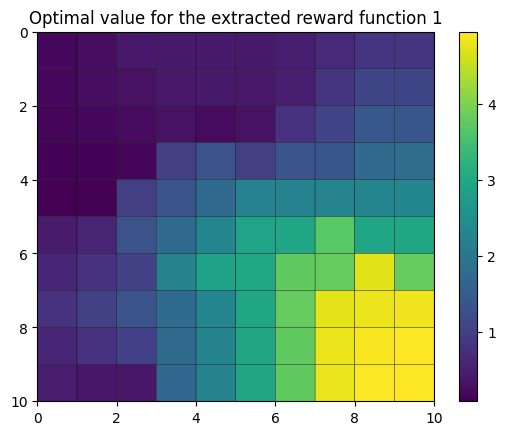

In [19]:
snapshots = get_state_value_snapshots(w, gamma, rewards, epsilon)
plot_heatmap(snapshots[-1], "Optimal value for the extracted reward function 1")

#### Question 15: (10 points) Compare the heat maps of Question 3 and Question 14 and provide a brief explanation on their similarities and differences.

> Ans: 

#### Question 16: (10 points) Use the extracted reward function found in question 13 to compute the optimal policy of the agent. For computing the optimal policy of the agent you need to use the function that you wrote in question 5. For visualization purpose, you should generate a figure similar to that of figure 1 but with the number of state replaced by the optimal action at that state. The actions should be displayed using arrows. In this question, you should have 1 plot.

> Ans:

In [20]:
optimal_policy = get_optimal_policy(w, gamma, rewards, epsilon)
optimal_policy

array([['→', '→', '→', '→', '↑', '←', '→', '→', '↓', '↓'],
       ['→', '→', '→', '↑', '↑', '↑', '→', '→', '↓', '↓'],
       ['↑', '↑', '↑', '↑', '↑', '↑', '→', '→', '↓', '↓'],
       ['↑', '↑', '→', '↓', '↓', '↓', '↓', '→', '↓', '↓'],
       ['↑', '↑', '→', '→', '↓', '↓', '↓', '↓', '↓', '↓'],
       ['↓', '↓', '→', '→', '↓', '↓', '↓', '↓', '↓', '↓'],
       ['↓', '↓', '↓', '→', '→', '→', '→', '↓', '↓', '↓'],
       ['→', '→', '→', '→', '→', '→', '→', '→', '↓', '↓'],
       ['↑', '↑', '↑', '→', '→', '→', '→', '→', '→', '↓'],
       ['↑', '↓', '←', '→', '→', '→', '→', '→', '→', '↓']], dtype='<U1')

#### Question 17: (10 points) Compare the figures of Question 5 and Question 16 and provide a brief explanation on their similarities and differences.

> Ans:

#### Question 18: (30 points) Sweep λ from 0 to 5 to get 500 evenly spaced values for λ. For each value of λ compute OA(s) by following the process described above. For this problem, use the optimal policy of the agent found in question 8 to fill in the OE(s) values. Then use equation 3 to compute the accuracy of the IRL algorithm for this value of λ. You need to repeat the above process for all 500 values of λ to get 500 data points. Plot λ (x-axis) against Accuracy (y-axis). In this question, you should have 1 plot.

> Ans:

  0%|          | 0/501 [00:00<?, ?it/s]

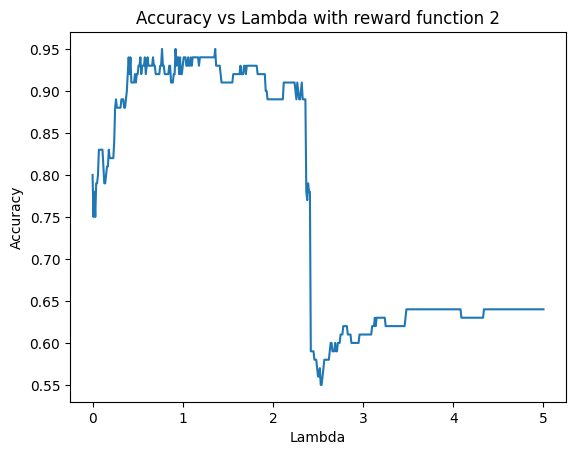

In [28]:
optimal_policy = get_optimal_policy(w, gamma, reward_func2, epsilon)
optimal_policy = optimal_policy.T.flatten()

r_max = reward_func2.max()
title = "Accuracy vs Lambda with reward function 2"
accs = plot_and_get_accuracies(lambdas, optimal_policy, gamma, r_max, title)

#### Question 19: (5 points) Use the plot in question 18 to compute the value of λ for which accuracy is maximum. For future reference we will denote this value as λ(2)max. Please report λ(2)max.

> Ans:

In [29]:
lambda_max2 = lambdas[np.argmax(accs)]
print("Max accuracy:", max(accs))
print("λ(2)max:", lambda_max2)

Max accuracy: 0.95
λ(2)max: 0.77


#### Question 20: (15 points) For λ(2)max, generate heat maps of the ground truth reward and the extracted reward. Please note that the ground truth reward is the Reward function 2 and the extracted reward is computed by solving the linear program given by equation 2 with the λ parameter set to λ(2)max. In this question, you should have 2 plots.

> Ans:

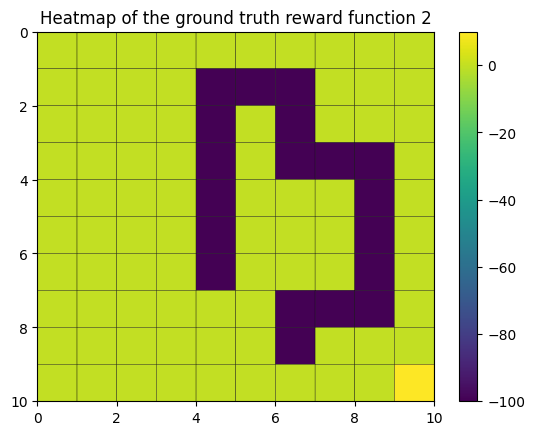

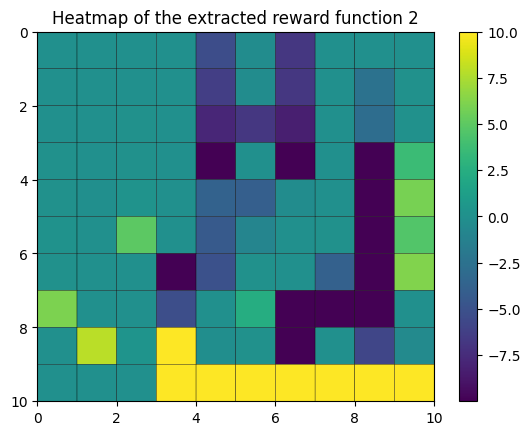

In [30]:
rewards = get_lp_rewards(optimal_policy, gamma, lambda_max2, r_max)
rewards = rewards.reshape(10,10).T
plot_heatmap(reward_func2, "Heatmap of the ground truth reward function 2")
plot_heatmap(rewards, "Heatmap of the extracted reward function 2")

#### Question 21: (10 points) Use the extracted reward function computed in question 20, to compute the optimal values of the states in the 2-D grid. For computing the optimal values you need to use the optimal state-value function that you wrote in question 2. For visualization purpose, generate a heat map of the optimal state values across the 2-D grid (similar to the figure generated in question 7). In this question, you should have 1 plot.

> Ans:

Number of steps to converge: 43


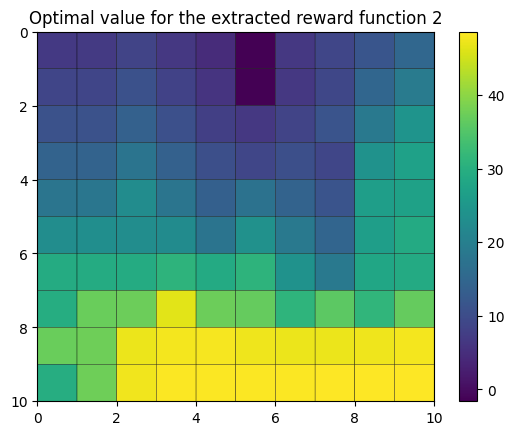

In [31]:
snapshots = get_state_value_snapshots(w, gamma, rewards, epsilon)
plot_heatmap(snapshots[-1], "Optimal value for the extracted reward function 2")

#### Question 22: (10 points) Compare the heat maps of Question 7 and Question 21 and provide a brief explanation on their similarities and differences.

> Ans:

#### Question 23: (10 points) Use the extracted reward function found in question 20 to compute the optimal policy of the agent. For computing the optimal policy of the agent you need to use the function that you wrote in question 9. For visualization purpose, you should generate a figure similar to that of figure 1 but with the number of state replaced by the optimal action at that state. The actions should be displayed using arrows. In this question, you should have 1 plot.

> Ans:

In [32]:
optimal_policy = get_optimal_policy(w, gamma, rewards, epsilon)
optimal_policy

array([['↓', '↓', '↓', '←', '←', '→', '→', '→', '→', '↓'],
       ['↓', '↓', '↓', '←', '←', '↑', '→', '→', '→', '↓'],
       ['↓', '↓', '↓', '←', '←', '↓', '→', '→', '→', '↓'],
       ['↓', '↓', '↓', '←', '←', '↓', '↓', '↑', '→', '↓'],
       ['↓', '↓', '↓', '←', '←', '↓', '↓', '↓', '→', '→'],
       ['↓', '↓', '↓', '←', '←', '↓', '↓', '←', '→', '↓'],
       ['↓', '↓', '↓', '↓', '↓', '↓', '←', '←', '→', '→'],
       ['↓', '↓', '↓', '↓', '↓', '↓', '←', '↓', '↓', '↓'],
       ['→', '→', '→', '↓', '↓', '↓', '↓', '↓', '↓', '↓'],
       ['→', '→', '→', '→', '↓', '←', '→', '↓', '→', '↓']], dtype='<U1')

#### Question 24: (10 points) Compare the figures of Question 9 and Question 23 and provide a brief explanation on their similarities and differences.

> Ans:

#### Question 25: (50 points) From the figure in question 23, you should observe that the optimal policy of the agent has two major discrepancies. Please identify and provide the causes for these two discrepancies. One of the discrepancy can be fixed easily by a slight modification to the value iteration algorithm. Perform this modification and re-run the modified value iteration algorithm to compute the optimal policy of the agent. Also, recompute the maximum accuracy after this modification. Is there a change in maximum accuracy? The second discrepancy is harder to fix and is a limitation of the simple IRL algorithm.

> Ans:

In [52]:
optimal_policy_truth = get_optimal_policy(w, gamma, reward_func2, epsilon)
print(optimal_policy_truth)

epsilon = 0.000001
optimal_policy = get_optimal_policy(w, gamma, rewards, epsilon)
acc = (optimal_policy_truth == optimal_policy).mean()
print("Accuracy after modification:", acc)
optimal_policy

[['↓' '↓' '↓' '←' '←' '→' '→' '→' '→' '↓']
 ['↓' '↓' '↓' '←' '←' '↑' '→' '→' '→' '↓']
 ['↓' '↓' '↓' '←' '←' '↓' '→' '→' '→' '↓']
 ['↓' '↓' '↓' '←' '←' '↓' '↓' '↑' '→' '↓']
 ['↓' '↓' '↓' '←' '←' '↓' '↓' '↓' '→' '↓']
 ['↓' '↓' '↓' '←' '←' '↓' '↓' '←' '→' '↓']
 ['↓' '↓' '↓' '↓' '↓' '↓' '←' '←' '→' '↓']
 ['↓' '↓' '↓' '↓' '↓' '↓' '←' '↓' '↓' '↓']
 ['→' '→' '→' '↓' '↓' '↓' '↓' '↓' '↓' '↓']
 ['→' '→' '→' '→' '→' '→' '→' '→' '→' '↓']]
Accuracy after modification: 1.0


array([['↓', '↓', '↓', '←', '←', '→', '→', '→', '→', '↓'],
       ['↓', '↓', '↓', '←', '←', '↑', '→', '→', '→', '↓'],
       ['↓', '↓', '↓', '←', '←', '↓', '→', '→', '→', '↓'],
       ['↓', '↓', '↓', '←', '←', '↓', '↓', '↑', '→', '↓'],
       ['↓', '↓', '↓', '←', '←', '↓', '↓', '↓', '→', '↓'],
       ['↓', '↓', '↓', '←', '←', '↓', '↓', '←', '→', '↓'],
       ['↓', '↓', '↓', '↓', '↓', '↓', '←', '←', '→', '↓'],
       ['↓', '↓', '↓', '↓', '↓', '↓', '←', '↓', '↓', '↓'],
       ['→', '→', '→', '↓', '↓', '↓', '↓', '↓', '↓', '↓'],
       ['→', '→', '→', '→', '→', '→', '→', '→', '→', '↓']], dtype='<U1')